In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold

In [ ]:
# Load the dataset
data = pd.read_csv('/content/kidney_disease_train.csv')
data

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,157,62.0,70.0,1.025,3.0,0.0,normal,abnormal,notpresent,notpresent,...,39.0,7900,3.9,yes,yes,no,good,no,no,ckd
1,109,54.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
2,17,47.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,NaN,NaN,NaN,yes,no,no,poor,no,no,ckd
3,347,43.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,43.0,7200,5.5,no,no,no,good,no,no,notckd
4,24,42.0,100.0,1.015,4.0,0.0,normal,abnormal,notpresent,present,...,39.0,8300,4.6,yes,no,no,poor,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,71,46.0,60.0,1.010,1.0,0.0,normal,normal,notpresent,notpresent,...,28.0,14600,3.2,yes,yes,no,good,no,no,ckd
276,106,50.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,17.0,6500,NaN,yes,yes,no,good,yes,yes,ckd
277,270,23.0,80.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,41.0,7200,5.0,no,no,no,good,no,no,notckd
278,348,38.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,44.0,7300,6.4,no,no,no,good,no,no,notckd


In [ ]:
# Separate numeric and categorical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# Fill missing values
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


In [ ]:
# Encode categorical columns if needed
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
print(data.columns)

# Replace 'classification_notckd' with the actual name of the target column
X = data.drop(columns=['classification_notckd'])
y = data['classification_notckd']

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod',
       ...
       'htn_yes', 'dm_\tyes', 'dm_no', 'dm_yes', 'cad_no', 'cad_yes',
       'appet_poor', 'pe_yes', 'ane_yes', 'classification_notckd'],
      dtype='object', length=151)


In [ ]:
# Replace 'target_column_name' with the actual name of the target column
X = data.drop(columns=['classification_notckd'])
y = data['classification_notckd']


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale the features
X_test_scaled = scaler.transform(X_test)  # Scale the test features

In [ ]:
# Convert y_train to a NumPy array if it's a DataFrame or Series
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)

# Store results for each fold
ann_results = []
sequential_results = []

# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# K-Fold Cross-Validation
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    # Model 1: Custom ANN
    ann_model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Use Input layer for input shape
        Dense(128, activation='leaky_relu'),
        Dropout(0.3),
        Dense(64, activation='leaky_relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    ann_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    ann_model.fit(X_train_fold, y_train_fold, epochs=500, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Evaluate ANN model
    ann_loss, ann_accuracy = ann_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    y_pred_ann = (ann_model.predict(X_val_fold) > 0.5).astype("int32")  # Convert probabilities to binary predictions
    r2_ann = r2_score(y_val_fold, y_pred_ann)

    # Store results
    ann_results.append((ann_loss, ann_accuracy, r2_ann))

    # Model 2: Sequential Model
    sequential_model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Use Input layer for input shape
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    sequential_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    sequential_model.fit(X_train_fold, y_train_fold, epochs=500, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose= 0)

    # Evaluate Sequential model
    sequential_loss, sequential_accuracy = sequential_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    y_pred_sequential = (sequential_model.predict(X_val_fold) > 0.5).astype("int32")  # Convert probabilities to binary predictions
    r2_sequential = r2_score(y_val_fold, y_pred_sequential)

    # Store results
    sequential_results.append((sequential_loss, sequential_accuracy, r2_sequential))

# Calculate average results for ANN
ann_avg_loss = np.mean([result[0] for result in ann_results])
ann_avg_accuracy = np.mean([result[1] for result in ann_results])

# Calculate average results for Sequential Model
sequential_avg_loss = np.mean([result[0] for result in sequential_results])
sequential_avg_accuracy = np.mean([result[1] for result in sequential_results])

# Print the average results
print(f"ANN Average Loss: {ann_avg_loss}, Average Accuracy: {ann_avg_accuracy}")
print(f"Sequential Model Average Loss: {sequential_avg_loss}, Average Accuracy: {sequential_avg_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
ANN Average Loss: 0.1492810383439064, Average Accuracy: 0.9598989963531495
Sequential Model Average Loss: 0.09656011699698866, Average Accuracy: 0.9643434405326843


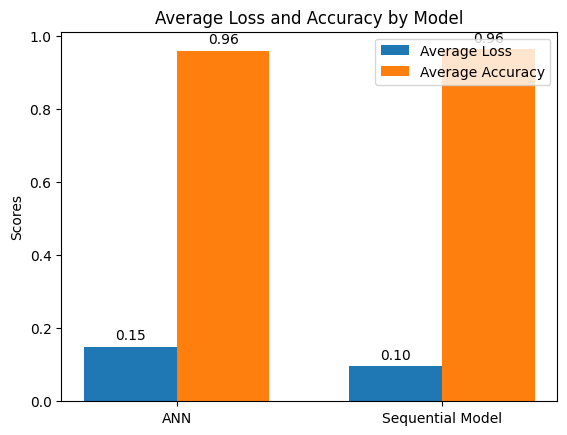

In [ ]:
# Visualization
import matplotlib.pyplot as plt
labels = ['ANN', 'Sequential Model']
avg_losses = [ann_avg_loss, sequential_avg_loss]
avg_accuracies = [ann_avg_accuracy, sequential_avg_accuracy]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, avg_losses, width, label='Average Loss')
bars2 = ax.bar(x + width/2, avg_accuracies, width, label='Average Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average Loss and Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

plt.show()